In [71]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qarin.evaluate.generators import create_fixtures_with_treatment
from nomenklatura.matching import LogicV1
from pathlib import Path
import json
from banal import ensure_list, hash_data
from followthemoney import model
from followthemoney.proxy import EntityProxy
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def e(schema: str, **kwargs) -> EntityProxy:
    props = {}
    for key, value in kwargs.items():
        if value is not None:
            props[key] = ensure_list(value)
    data = {"schema": schema, "properties": props, "id": hash_data(props)}
    return EntityProxy.from_dict(model, data)

DATAPATH = Path.cwd().parent / "data"

import requests
# Verify that there is a local version of Yente running on port 8000
URL = "http://localhost:8000"
r = requests.get(URL)
assert r.status_code == 200
# Verify that we have data loaded
BATCH = {"queries": {"q1": {"schema": "Person", "properties":{"name": "Vladimir Putin"}}}}
PARAMS = {"algorithm": "best", "fuzzy": "false", "threshold": 1.00}
response = requests.post(URL+'/match/sanctions/', json=BATCH, params=PARAMS)
responses = response.json().get("responses")
assert len(responses["q1"]["results"]) > 0

### Evaluating algorithms on Faker data
This simply runs our algorithms on names generated through Faker and run through a set of mutations that simulate spelling errors, names with different spellings depending on culture, etc. The main use of this would be to have a dataset that can be used to demonstrate the quality of our algorithms over multiple iterations.

In [21]:
# Create Faker based data as something to evaluate individual algorithms on
if not (DATAPATH / "test_data.json").exists():
    create_fixtures_with_treatment(DATAPATH / "test_data.json", n=100)

# Run the LogicV1 algorithm on the training data, recording the score
arr = []
with open(DATAPATH / "test_data.json", "r") as fp:
    for d in json.load(fp):
        d["algorithm"] = "LogicV1"
        d["scores"] = {}
        original = EntityProxy.from_dict(
            model,
            d["original"],
        )
        for treatment in d["changed"].keys():
            changed = EntityProxy.from_dict(
                model,
                d["changed"][treatment],
            )
            score = LogicV1.compare(original, changed).score
            d["scores"][treatment] = score
        arr.append(d)
    

/home/simon/.cache/pypoetry/virtualenvs/qarin-wd4neksq-py3.11/lib/python3.11/site-packages/fingerprints/cleanup.py:66: ICUWarning: Install 'pyicu' for better text transliteration.
  text = ascii_text(text)


In [22]:
from collections import defaultdict
treatment_values = defaultdict(list)
[treatment_values[k].append(s) for x in arr for (k, s) in x["scores"].items()];

Text(0.5, 1.0, 'LogicV1 accuracies on Faker data after mutations')

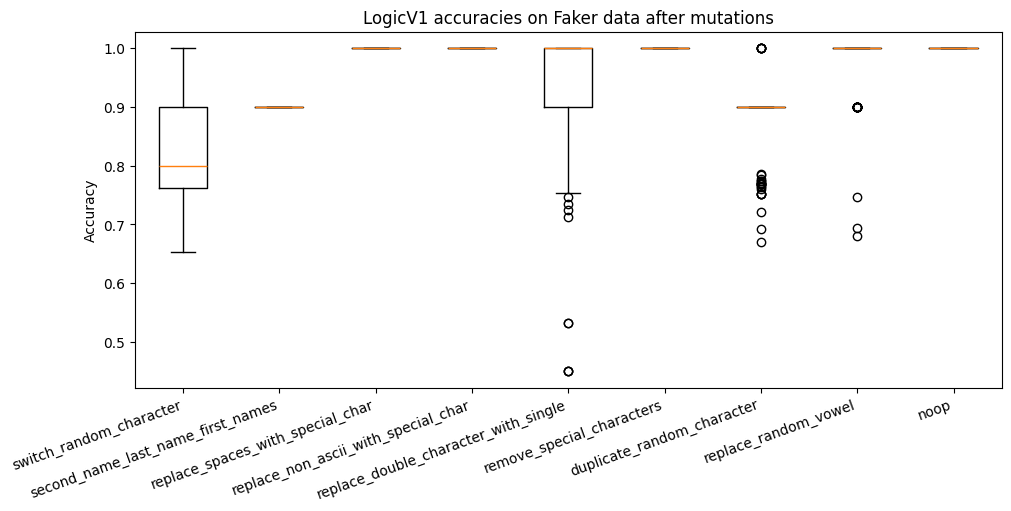

In [23]:
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained') 
b = ax.boxplot(treatment_values.values())
ax.set_xticks(range(1, len(treatment_values.keys()) + 1))
ax.set_xticklabels(treatment_values.keys(), rotation=20, ha='right')
ax.set_ylabel("Accuracy")
ax.set_title("LogicV1 accuracies on Faker data after mutations")

## E2E Yente evaulation

Run a local, full featured version of Yente. Test data both for recall and precision.

### False negative testing
Testing for false negatives means testing how likely it is that Yente is unable to match a name to an entity that exists in the database. We expect to always be able to make succesful match if a query has a 100% match in the data, but there are several cases where we'd expect a query to differ slightly from the data itself. Some sample error cases are

* Spelling and typing errors (Simon vs Smion)
* Names that differ over cultures (Alex, Alexander, Oleksandr)
* Names where only parts are in use (Pablo Diego José Francisco de Paula Juan Nepomuceno Cipriano de la Santísima Trinidad Ruiz Picasso vs Pablo Picasso)
* Encoding errors (ASCII transliterated text, text where unicode characters have been replaced with question marks)
* Names where the part order differs (Luis Theroux vs Theroux, Luis)
  
To test for this we take a name that exists in the dataset, add a number of mutations and note the score changes when querying the mutated version of the name against Yente.

TODO: This assumes that any sampled name from the data performs the same, We should look into how we perform on different sections of the dataset as well.

In [297]:
import random, itertools
from collections import OrderedDict

def batch_list(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [161]:
from datetime import datetime
from elasticsearch import Elasticsearch
# Get a set of 1000 random names directly from ElasticSearch 
client = Elasticsearch("http://localhost:9200/", api_key="YOUR_API_KEY")
q = {
    "function_score": {
        "query": { "match": {"schema": "Person"} },
        "random_score": {
            "seed": 10,
            "field": "name_keys"
        },
    }
}
resp = client.search(index="yente-entities-default-00920240413005339", query=q, size=1000)

In [289]:
PARAMS = {"algorithm": "best", "fuzzy": "false", "threshold":0.1}
responses = []
for batch in batch_list(resp["hits"]["hits"], 10):
    i = 0
    q = {"queries": {}}
    for original in batch:
        c = {}
        d = e("Person", **original["_source"]["properties"])
        escaped_name = d.caption.replace(" ", "_")
        i+=1
        # Run the name through each treatment and save it unless it is equal to the original
        for treatment, changed in g.add_treatments(d).items():
            if d.caption == changed.caption and treatment != "noop":
                continue
            c[treatment] = changed.get("name")
        for treatment, changed_name in c.items():
            q["queries"][f"q_{i}_{treatment}+{escaped_name}"] = {
                "schema": "Person",
                "properties": {
                    "name": changed_name
                }
            }
    # Test the name against Yente
    response = requests.post(URL+'/match/default/', json=q, params=PARAMS)
    for k, v in response.json().get("responses").items():
        k, original_name = k.split("+")
        v["original"] = original_name.replace("_", " ")
        v["treatment"] = "_".join(k.split("_")[2:])
        responses.append(v)

To get a proper view of the data 

In [290]:
# Create a list of scores for each treatment type
treatment_values = defaultdict(list)
for response in responses:
    found_original = False
    results = sorted(response["results"], key=lambda r: r["score"])
    # Add the score of the original to the results for that treatment
    for result in response["results"]:
        if result["caption"] == response["original"]:
            treatment_values[response["treatment"]].append(result["score"])
            found_original = True
            break
    # If the original was not found or no results were returned we record that as a score of 0.0
    if found_original == False:
        treatment_values[response["treatment"]].append(0.0)
    

## Evaluation
The performance of Yente on each type of treated data can now be plotted.

Text(0.5, 1.0, 'Yente accuracies on existing data after mutations')

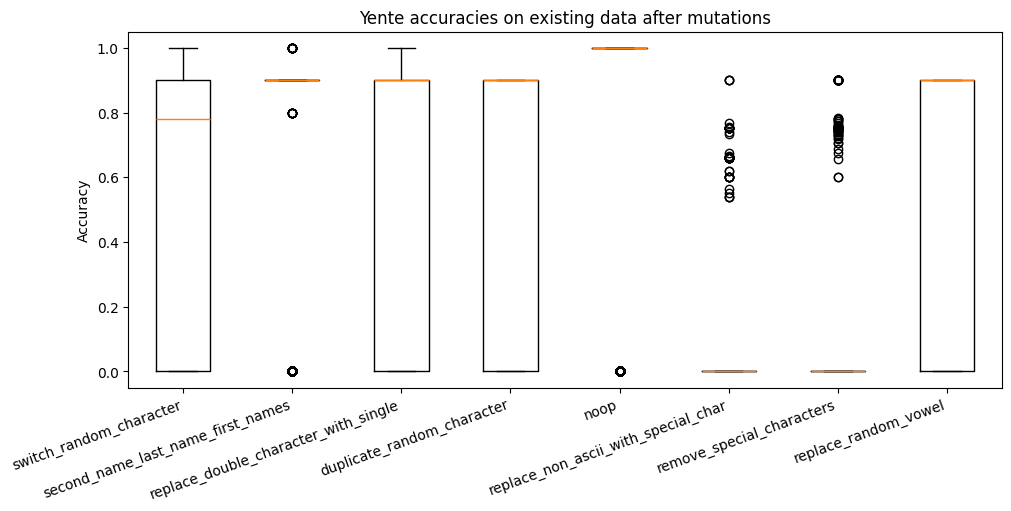

In [291]:
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained') 
b = ax.boxplot(treatment_values.values())
ax.set_xticks(range(1, len(treatment_values.keys()) + 1))
ax.set_xticklabels(treatment_values.keys(), rotation=20, ha='right')
ax.set_ylabel("Accuracy")
ax.set_title("Yente accuracies on existing data after mutations")

There are a number of things that stand out here
1. The `noop` operation does not change the name at all, so you would expect it to always return a 100% match. It seems there are some with a score 0.0, which should not exist.
2. Replacing or removing special characters have very low scores. This can be because a large part of the non-ascii names are in a non-latin alphabet and the entire name would be replaced with a question mark, i.e. Alejandro Nuñez is still readable as Alejandro Nu?ez, but Руслан Израилович Кастоев cannot be recognized if it is ?????? ?????????? ???????. This is more of a case of garbage in / garbage out than anything and probably not something we need to take into account.
3. Several treatments have an average accuracy conspicuously close to 0.9. This is most likely due to some of the features relying on whole number changes. The main risk in that lies in that we tend to choose round numbers as thresholds, so making sure the threshold falls on the right side of the bin becomes far more important than it would with a more normal distribution of scores.
4. `second_name_last_name_first_names` essentially only has 4 values. It may be possible to create special cases that cover the entire category.

### False positive testing
False positives is when a match is wrongly reported on a query and a thing in the database. To test for it we will follow the PWC approach and generate fake names with `Faker` and then check that there are no exact matches for that name in Yente. If there were matches with a score less than 1.0 we check if any of them are above a given threshold, e.g. 0.8. Any matches above that threshold are recorded as false positives.

In [292]:
from qarin.evaluate.generators import PersonGenerator
g = PersonGenerator(locales=locale_probs)

In [344]:
# Set the count of each locale here
locale_probs = OrderedDict({
    "ru_RU": 140e6,
    "es_ES": 40e6,
})

locales = list(locale_probs.keys())
cum_weights = list(itertools.accumulate(locale_probs.values()))
def get_locale() -> str:
    return random.choices(locales, cum_weights=cum_weights, k=1)[0]

arr = []
for j in range(0, 1000):
    locale = get_locale()
    d = g.generate(locale=locale)
    BATCH = {"queries": {"q1": d.to_dict()}}
    PARAMS = {"algorithm": "best", "fuzzy": "false"}
    # Send the batch off to the API and raise an exception for a non-OK response code.
    response = requests.post(URL+'/match/default/', json=BATCH, params=PARAMS)
    response.raise_for_status()
    responses = response.json().get("responses")
    exact_match = False
    for res in responses["q1"]["results"]:
        if res["score"] == 1.0:
            exact_match = True
            break
    if exact_match:
        continue
    arr.append({"person": d, "lang": locale, "results": responses["q1"]["results"]})

In [341]:
had_false_positive = []
for i, a in enumerate(arr):
    for res in a["results"]:
        if res["score"] >= 0.8:
            had_false_positive.append(i)
            break

In [343]:
arr

[]

In [313]:
PARAMS = {"algorithm": "best", "fuzzy": "false", "threshold":0.8}
responses = []

for persons in batch(arr, 10):
    q = {"queries": {}}
    i = 0
    for p in persons:
        for treatment, changed in p["changed"].items():
            i+=1
            q["queries"][f"q{i}_{treatment}+{p['person'].caption.replace(' ', '_')}"] = {
                "schema": "Person",
                "properties": {
                    "name": changed.get("name")
                }
            }
    response = requests.post(URL+'/match/default/', json=q, params=PARAMS)
    responses += response.json().get("responses").values()

In [314]:
[response for response in responses if len(response["results"]) > 0] 

[]

In [335]:
arr[7]

{'person': <E('4d183ac1-5baa-4233-8fc3-0696ba77444a','Heriberto Ramos')>,
 'lang': 'es_ES',
 'results': [{'id': 'cl-info-probidad-5aa21e8b8eb2bea7768e9968573000c8',
   'caption': 'JOSÉ HERIBERTO VILLA RAMOS',
   'schema': 'Person',
   'properties': {'firstName': ['JOSÉ HERIBERTO'],
    'motherName': ['RAMOS'],
    'topics': ['role.pep'],
    'name': ['JOSÉ HERIBERTO VILLA RAMOS'],
    'sourceUrl': ['http://datos.cplt.cl/datos/infoprobidad/5aa21e8b8eb2bea7768e9968573000c8'],
    'country': ['cl'],
    'fatherName': ['VILLA']},
   'datasets': ['cl_info_probidad'],
   'referents': [],
   'target': True,
   'first_seen': '2024-01-17T02:50:01',
   'last_seen': '2024-04-15T02:50:01',
   'last_change': '2024-01-17T02:50:01',
   'score': 0.9,
   'features': {'person_name_jaro_winkler': 1.0,
    'person_name_phonetic_match': 1.0},
   'match': True},
  {'id': 'br-pep-64a2bc304d6977dcc1fb3fd0c8d93025bf555e68',
   'caption': 'LUCIO HERBERT SOUSA RAMOS',
   'schema': 'Person',
   'properties': {'to